In [61]:
import numpy as np
import math
from sympy import symbols, lambdify, I, latex
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

%config InlineBackend.figure_format = 'retina'

In [62]:
# Define all the variables
x = symbols("x")
x_bar = symbols(r"\bar{x}")
omega_0 = symbols(r"\omega_0", real = True)

# Define function: h_2n
def h_2n(n_val, x_val, x_bar_val, omega_0_val):
	return ((-1)**(n_val+1) * omega_0_val**2 / math.factorial(2*n_val)) * (1 / (2*omega_0_val))**n_val * (x_val + x_bar_val)**(2*n_val)

# Define the Hamiltonian function: h 
h = omega_0 * x * x_bar

for i in range(2,4):
	h += h_2n(i*2, x, x_bar, omega_0)

h

\bar{x}*\omega_0*x - (\bar{x} + x)**8/(645120*\omega_0**2) - (\bar{x} + x)**12/(30656102400*\omega_0**4)

In [63]:
def compose(f, n):
    # from https://stackoverflow.com/a/58850806/6454085
    def fn(x):
        for _ in range(n):
            x = f(x)
        return x
    return fn

def poisson_bracket(f, g, q, p):
    return I * f.diff(q) * g.diff(p) - I * f.diff(p) * g.diff(q)
pb = lambda f,g: poisson_bracket(f, g, x_bar, x)

def lie_transformation(f, chi, order):
    fp = 0
    for i in range(order):
        fp += 1/math.factorial(i) * compose(lambda f: pb(f, chi), i)(f)
    return fp

chi_4 = 1/(I*omega_0) * (x**3 * x_bar/48 - x*x_bar**3/48 - x_bar**4/384 + x**4/384)
chi_6 = 1/(I*omega_0**2) *  (-x**6/15360 + x**5*x_bar/15360 + 7*x**4*x_bar**2/3072 - 7*x**2*x_bar**4/3072 - x*x_bar**5/15369 + x_bar**6/15360)

chi = chi_4+chi_6

# xp = x + pb(x, chi) + (1/2) * pb(pb(x, chi), chi)
# xp_bar = x_bar + pb(x_bar, chi) + (1/2) * pb(pb(x_bar, chi), chi)

lie_order = 3
xp = lie_transformation(x, chi, lie_order)
xp_bar = lie_transformation(x_bar, chi, lie_order)

xp_f = lambdify([x, x_bar, omega_0], xp)
xp_bar_f = lambdify([x, x_bar, omega_0], xp_bar)

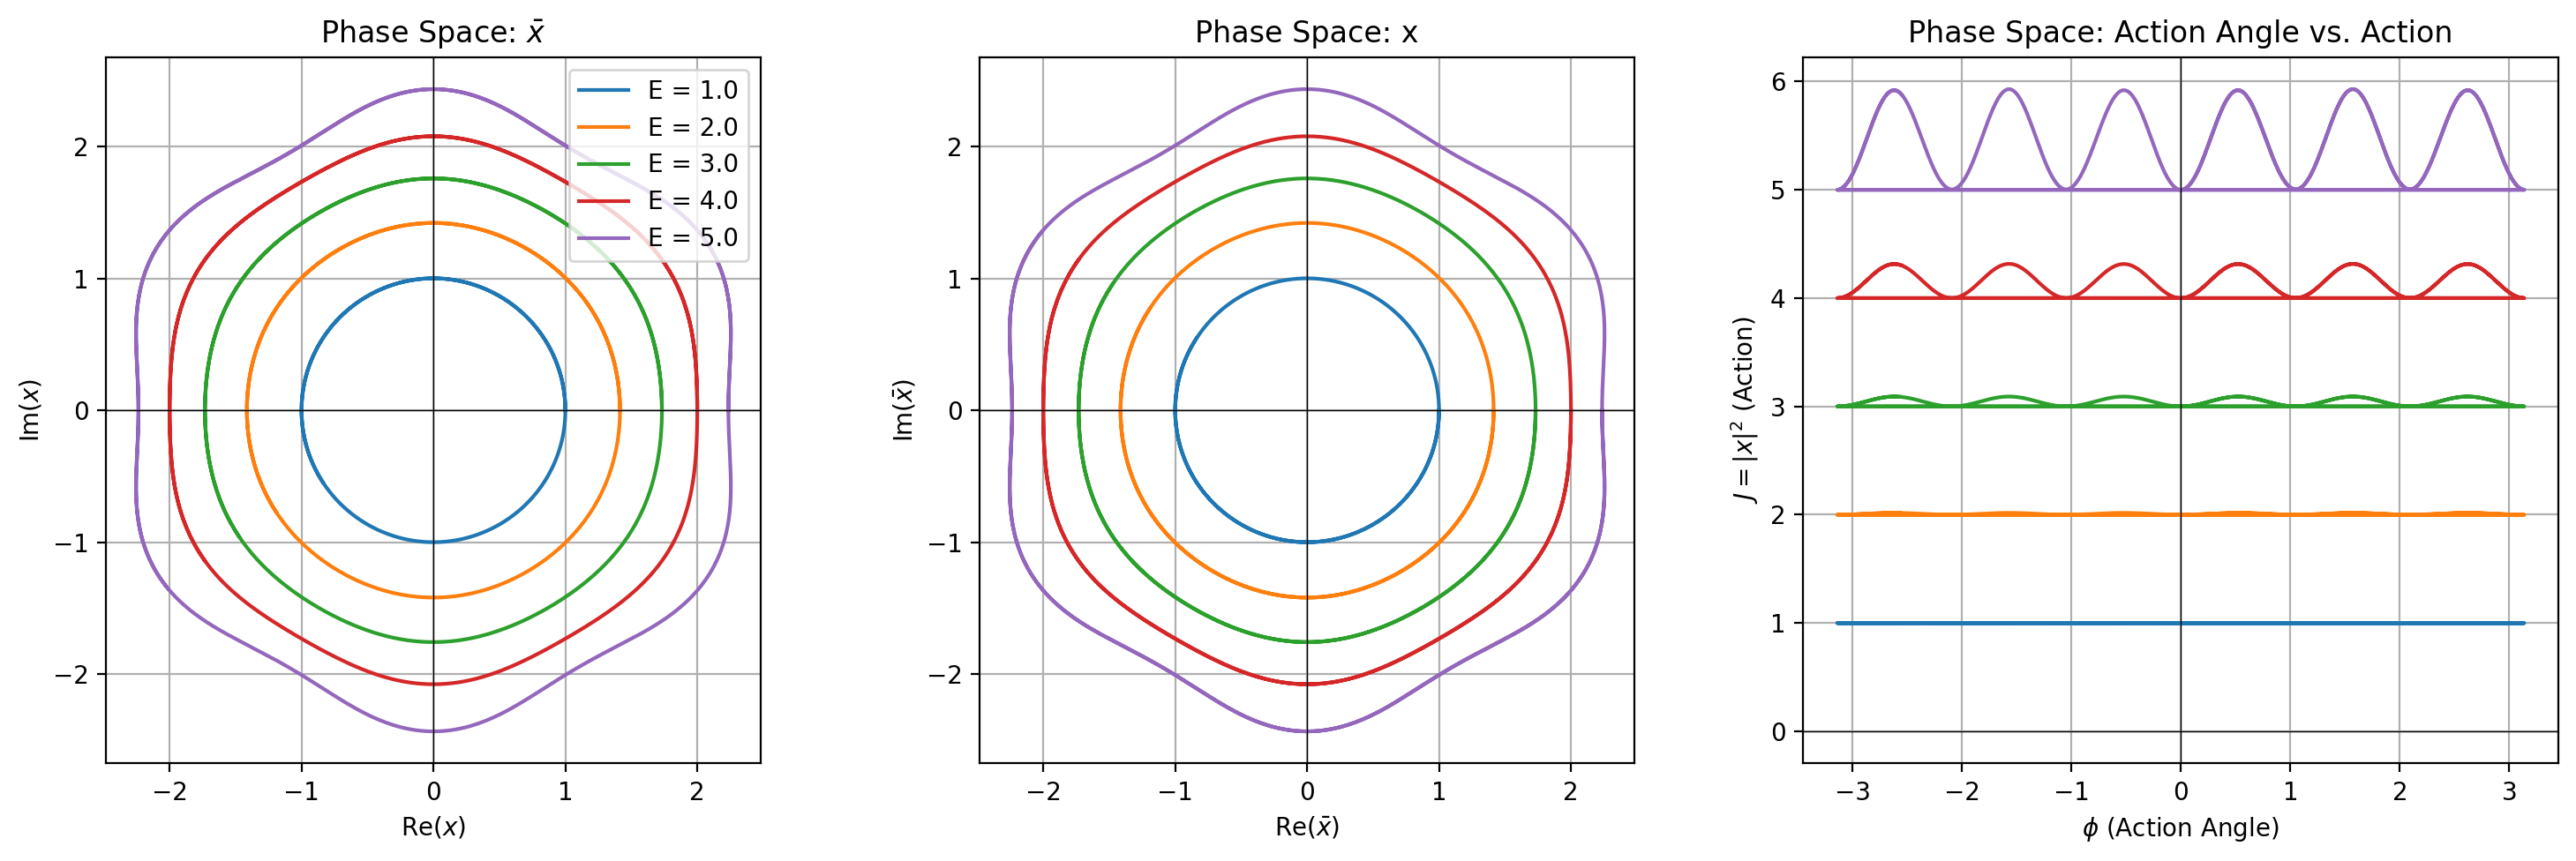

In [64]:
# Differentiate with respect to x and x_bar
difeq_x = lambdify([x, x_bar, omega_0], h.diff(x) * I)
difeq_x_bar = lambdify([x, x_bar, omega_0], h.diff(x_bar) * I)

# Natural frequency of the system
omega_0_val = 1.0

# Define the Hamiltonian system in terms of x and x bar
def hamiltonian_system(time, z):
    x, x_bar = z[0] + 1j * z[1], z[2] + 1j * z[3]  # Convert to complex form
    dxdt = difeq_x_bar(x, x_bar, omega_0_val)
    dx_bardt = difeq_x(x, x_bar, omega_0_val)
    return [dxdt.real, dxdt.imag, dx_bardt.real, dx_bardt.imag]

# Define different energy levels for hamiltonian
energy_levels = [1.0, 2.0, 3.0, 4.0, 5.0]

t_span = (0, 10)
t_eval = np.linspace(*t_span, 1000)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(energy_levels)):
    H = energy_levels[i]
    # Set initial condition for x and x̄ based on chosen 
	# energy H as sqrt(H/omega_0) with phase as 0
    x0 = np.sqrt(H/omega_0_val) * np.exp(0)
    x_bar0 = np.conj(x0)
    z0 = [x0.real, x0.imag, x_bar0.real, x_bar0.imag]

    # Solve the ODEs
    sol = solve_ivp(hamiltonian_system, t_span, z0, t_eval=t_eval, rtol=1e-8, atol=1e-8)
    x_sol = sol.y[0] + 1j * sol.y[1]
    x_bar_sol = sol.y[2] + 1j * sol.y[3]

    # Compute action variable J and action angle phi
    J_sol = np.abs(x_sol) ** 2
    phi_sol = np.angle(x_sol)

    # Plot phase space for x
    axes[0].plot(x_sol.real, x_sol.imag, label=f"E = {H:.2}")
    
	# Plot phase space for x_bar
    axes[1].plot(np.conj(x_sol).real, np.conj(x_sol).imag)

    # Plot angle space
    axes[2].plot(phi_sol, J_sol)
    
axes[0].legend(loc="upper right")
axes[0].set_xlabel(r'Re$(x)$')
axes[0].set_ylabel(r'Im$(x)$')
axes[0].set_title(r'Phase Space: $\bar{x}$')
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].axvline(0, color='black', linewidth=0.5)
axes[0].grid()
axes[0].set_aspect('equal')

axes[1].set_xlabel(r'Re$(\bar{x})$')
axes[1].set_ylabel(r'Im$(\bar{x})$')
axes[1].set_title('Phase Space: x')
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axvline(0, color='black', linewidth=0.5)
axes[1].grid()
axes[1].set_aspect('equal')

axes[2].set_xlabel(r'$\phi$ (Action Angle)')
axes[2].set_ylabel(r'$J = |x|^2$ (Action)')
axes[2].set_title('Phase Space: Action Angle vs. Action')
axes[2].axhline(0, color='black', linewidth=0.5)
axes[2].axvline(0, color='black', linewidth=0.5)
axes[2].grid()

plt.tight_layout()
plt.show()

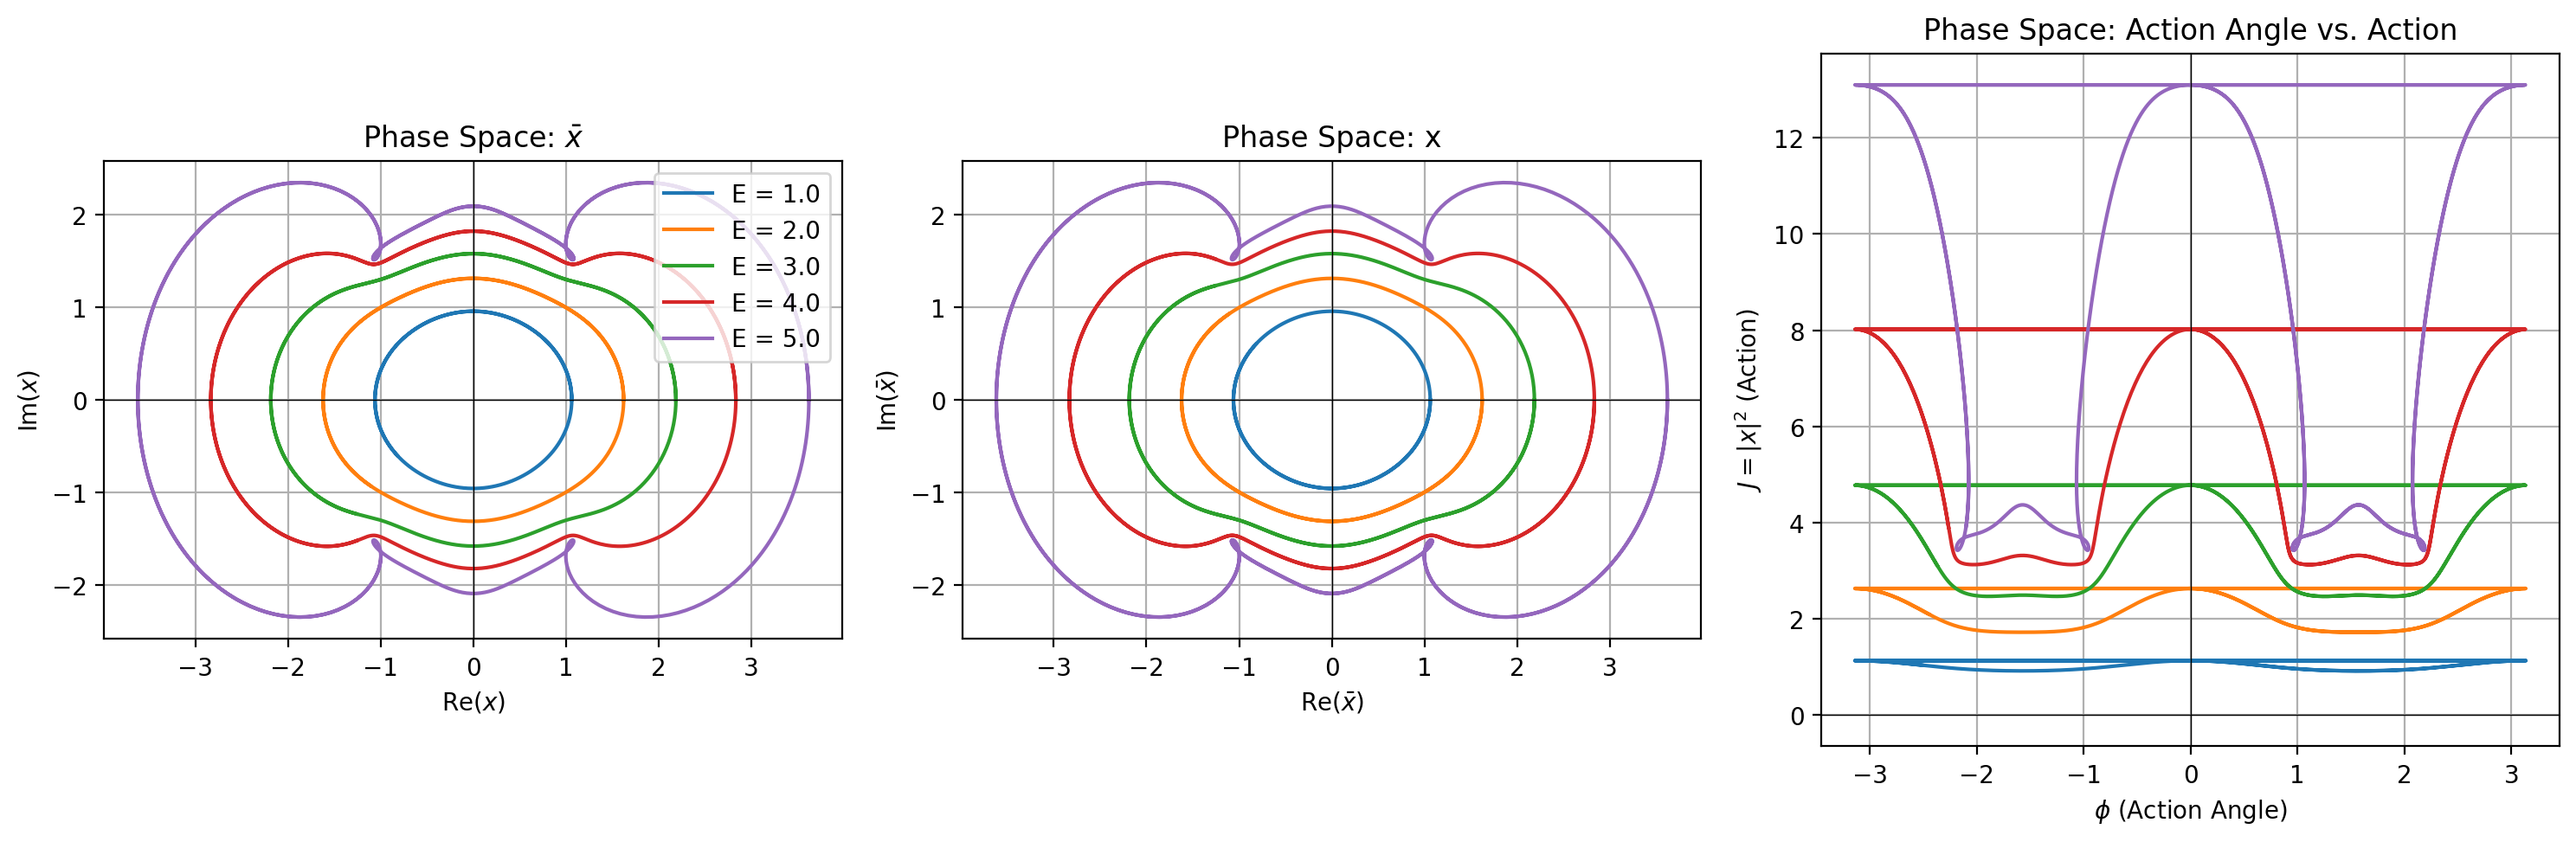

In [65]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(energy_levels)):
    H = energy_levels[i]
    # Set initial condition for x and x̄ based on chosen 
	# energy H as sqrt(H/omega_0) with phase as 0
    x0 = np.sqrt(H/omega_0_val) * np.exp(0)
    x_bar0 = np.conj(x0)
    z0 = [x0.real, x0.imag, x_bar0.real, x_bar0.imag]

    # Solve the ODEs
    sol = solve_ivp(hamiltonian_system, t_span, z0, t_eval=t_eval, rtol=1e-8, atol=1e-8)
    x_sol = sol.y[0] + 1j * sol.y[1]
    x_bar_sol = sol.y[2] + 1j * sol.y[3]

    xp_sol = xp_f(x_sol, x_bar_sol, omega_0_val)
    xp_bar_sol = xp_bar_f(x_sol, x_bar_sol, omega_0_val)

    # Compute action variable J and action angle phi
    J_sol = np.abs(xp_sol) ** 2
    phi_sol = np.angle(xp_sol)

    # Plot phase space for x
    axes[0].plot(xp_sol.real, xp_sol.imag, label=f"E = {H:.2}")
    
	# Plot phase space for x_bar
    axes[1].plot(np.conj(xp_sol).real, np.conj(xp_sol).imag)

    # Plot angle space
    axes[2].plot(phi_sol, J_sol)
    
axes[0].legend(loc="upper right")
axes[0].set_xlabel(r'Re$(x)$')
axes[0].set_ylabel(r'Im$(x)$')
axes[0].set_title(r'Phase Space: $\bar{x}$')
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].axvline(0, color='black', linewidth=0.5)
axes[0].grid()
axes[0].set_aspect('equal')

axes[1].set_xlabel(r'Re$(\bar{x})$')
axes[1].set_ylabel(r'Im$(\bar{x})$')
axes[1].set_title('Phase Space: x')
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axvline(0, color='black', linewidth=0.5)
axes[1].grid()
axes[1].set_aspect('equal')

axes[2].set_xlabel(r'$\phi$ (Action Angle)')
axes[2].set_ylabel(r'$J = |x|^2$ (Action)')
axes[2].set_title('Phase Space: Action Angle vs. Action')
axes[2].axhline(0, color='black', linewidth=0.5)
axes[2].axvline(0, color='black', linewidth=0.5)
axes[2].grid()

plt.tight_layout()
plt.show()